In [88]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import KernelPCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, MiniBatchKMeans, AffinityPropagation

from rosvm.ranksvm.kernel_utils import generalized_tanimoto_kernel, tanimoto_kernel

In [53]:
def load_features(spectrum, fps_definition, db_fn="/home/bach/Documents/doctoral/projects/local_casmi_db/db/use_inchis/DB_LATEST.db"):
    db = sqlite3.connect(db_fn)

    fps_dimension = db.execute("SELECT length FROM fingerprints_meta WHERE name IS '%s'" % (fps_definition, )).fetchall()[0][0]

    df = pd.read_sql_query(
        "SELECT spectrum, molecule, %s FROM candidates_spectra"
        "   INNER JOIN fingerprints_data ON candidates_spectra.candidate = fingerprints_data.molecule"
        "   WHERE spectrum IS '%s'" % (fps_definition, spectrum),
        db
    )

    # Convert the sparse fingerprint representation to dense one
    X = np.zeros((df.shape[0], fps_dimension))
    for i, row in df.iterrows():
        if fps_definition == "substructure_count":
            _fp = eval("{" + row[fps_definition] + "}")
            X[i, list(_fp.keys())] = list(_fp.values())
        else:
            _ids = list(map(int, row[fps_definition].split(",")))
            X[i, _ids] = 1
        
    db.close()
    
    return X

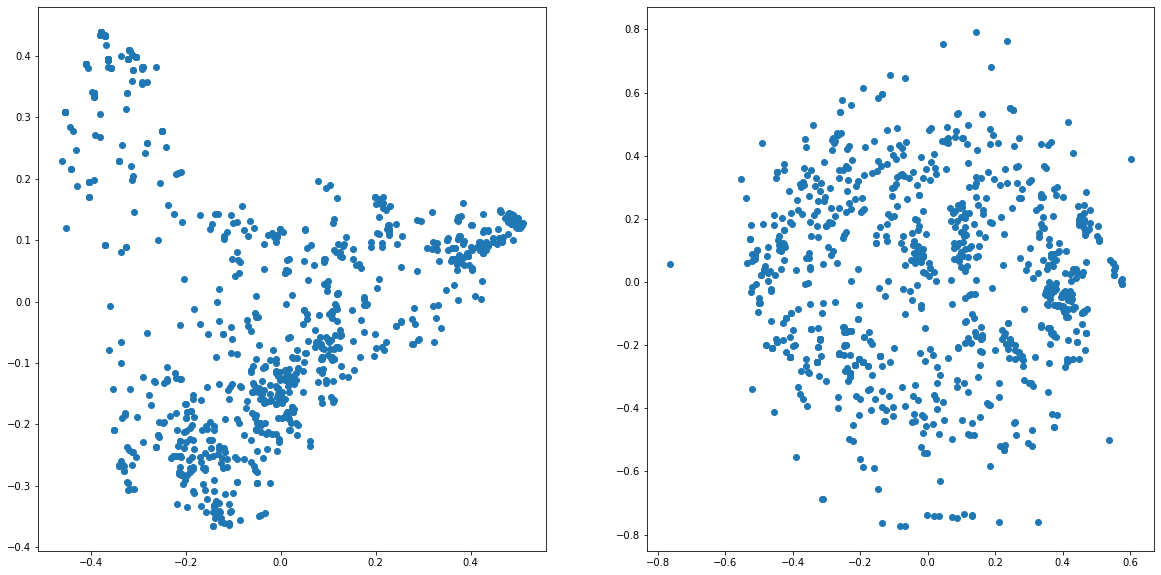

In [66]:
KX = tanimoto_kernel(load_features("Challenge-101", "iokr_fps__positive"))
# KX = generalized_tanimoto_kernel(load_features("Challenge-101", "substructure_count"))

Z_pca = KernelPCA(n_components=2, n_jobs=4, kernel="precomputed").fit_transform(KX)
Z_mds = MDS(n_components=2, n_jobs=4, dissimilarity="precomputed").fit_transform(1 - KX)

fig, axrr = plt.subplots(1, 2, figsize=(20, 10))
axrr[0].scatter(Z_pca[:, 0], Z_pca[:, 1])
axrr[1].scatter(Z_mds[:, 0], Z_mds[:, 1])

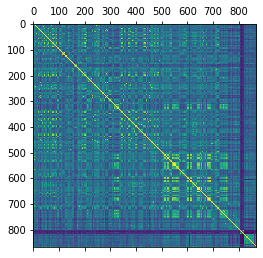

In [131]:
plt.matshow(KX)

In [188]:


# X = load_features("Challenge-034", "iokr_fps__positive")
X = load_features("Challenge-033", "substructure_count")
KX = generalized_tanimoto_kernel(X)

Z_pca = KernelPCA(n_components=2, n_jobs=4, kernel="precomputed").fit_transform(KX)
Z_mds = MDS(n_components=2, n_jobs=4, dissimilarity="precomputed").fit_transform(1 - KX)

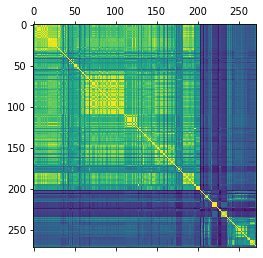

In [189]:
plt.matshow(KX)

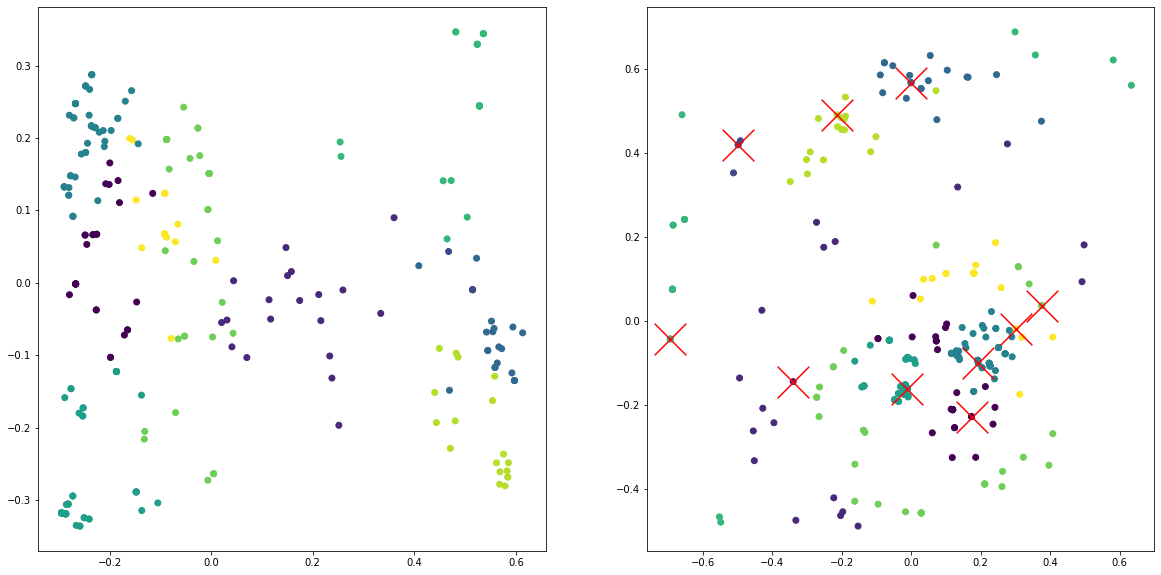

In [190]:
def get_centroids(S, cluster):
    c = cluster.fit_predict(S)
    
    centroids = []
    idc = np.arange(len(c))
    for label in np.unique(c):
        idx_of_centroid = idc[c == label][np.argsort(np.median(S[np.ix_(c == label, c == label)], axis=0))[::-3][:1]] 
        centroids.append(idx_of_centroid)

    return c, centroids

c, cen = get_centroids(KX, MiniBatchKMeans(n_clusters=10, n_init=20, init='k-means++'))

fig, axrr = plt.subplots(1, 2, figsize=(20, 10))
axrr[0].scatter(Z_pca[:, 0], Z_pca[:, 1], c=c)
axrr[1].scatter(Z_mds[:, 0], Z_mds[:, 1], c=c)
axrr[1].scatter(Z_mds[cen, 0], Z_mds[cen, 1], c="red", marker="x", s=1000)

In [148]:
Z_mds[cen, 0]

array([ 0.04340301, -0.40268335,  0.37689795,  0.46666394, -0.00652842,
       -0.36619133,  0.27165585, -0.11956878])

In [86]:
c = MiniBatchKMeans().fit_predict(X)

In [75]:
X = load_features("Challenge-100", "iokr_fps__positive")
y = KMeans(X).fit_predict()

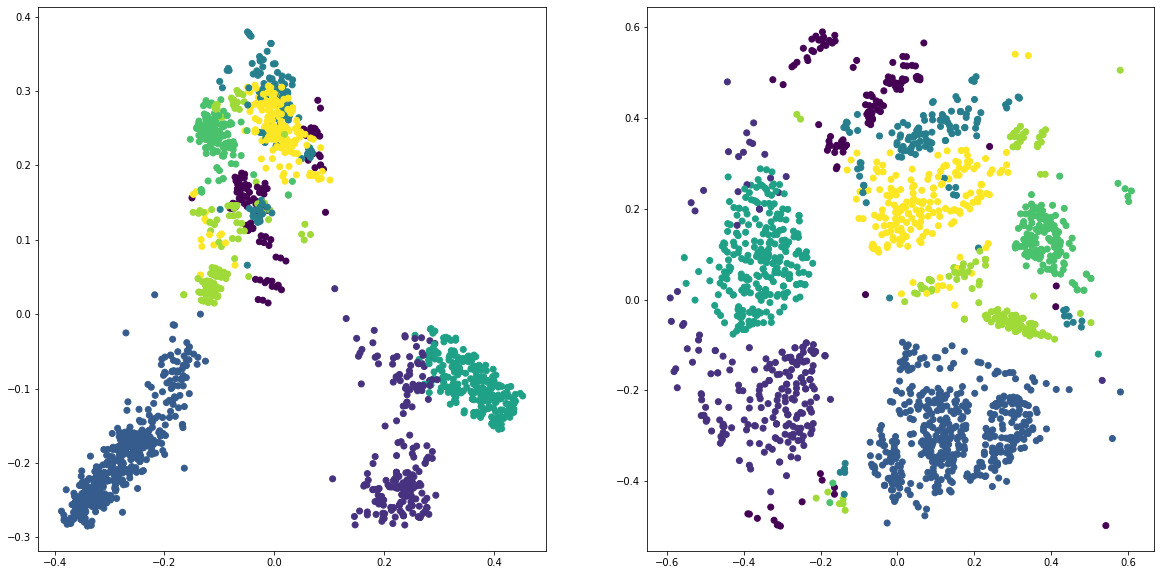

In [78]:
fig, axrr = plt.subplots(1, 2, figsize=(20, 10))
axrr[0].scatter(Z_pca[:, 0], Z_pca[:, 1], c=y)
axrr[1].scatter(Z_mds[:, 0], Z_mds[:, 1], c=y)